In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
dfTrain = pd.read_csv('../data/TRAIN_TEST_corrected2/train_corrected2.csv').sample(frac=0.05)
train = dfTrain.drop(columns=['price_usd', 'id'], axis=1)
target = dfTrain.price_usd

In [14]:
# NORMALIZACION DEL DATASET:

##########################################################################
#MinMaxScaler                                                            #
#scaler = MinMaxScaler(feature_range=(0, 1))                             #
#train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)#
##########################################################################

##########################################################################
#Normalizer                                                              #
scaler = Normalizer().fit(train)                                         #
train = pd.DataFrame(scaler.transform(train), columns=train.columns)     #
##########################################################################

In [15]:
train.head(3)

,year_created,month_created,day_created,distance_to_obelisco_mtrs,lat,lon,surface_total_in_m2,rooms,PH,apartment,house,store
0,1.0,0.272727,0.133333,0.001881,0.018110,0.275147,0.026690,0.0625,0.0,0.0,1.0,0.0
1,0.2,0.636364,0.966667,0.000538,0.016393,0.275887,0.002521,0.0625,0.0,1.0,0.0,0.0
2,1.0,0.363636,0.266667,0.436537,0.635064,0.094638,0.025059,0.0625,0.0,0.0,1.0,0.0


In [16]:
# PARAMETROS PARA KNN
# Aca estoy definiendo 2 grillas
# (esto me sirve para hacer una que incluya distancia hamming con ball-tree y las demas con kd-tree)
param_grid = [
                {'n_neighbors': [5, 10, 15, 20, 25, 30, 40, 50, 75],
                 'weights': ['uniform', 'distance'],
                 'metric': ['euclidean', 'manhattan', 'chebyshev']}]

# MEDIDA DE SCORE PARA CROSS-VALIDATION
scoring = {'MSE': 'neg_mean_squared_error'}

knn = KNeighborsRegressor(n_jobs=-1)
gs = GridSearchCV(knn, scoring=scoring, param_grid=param_grid, cv=10, refit='MSE', return_train_score=False)

In [17]:
# COMIENZO EL GRID SEARCH
gs.fit(train, target);

In [18]:
results = gs.cv_results_
dfResults = pd.DataFrame(results).loc[:, ('rank_test_MSE', 'mean_test_MSE', 
                                          'param_metric', 'param_n_neighbors', 'param_weights')].infer_objects()

In [19]:
dfResults.sort_values(by='rank_test_MSE').head(10)

,rank_test_MSE,mean_test_MSE,param_metric,param_n_neighbors,param_weights
29,1,-7.409746e+10,manhattan,30,distance
31,2,-7.411265e+10,manhattan,40,distance
27,3,-7.421716e+10,manhattan,25,distance
33,4,-7.423582e+10,manhattan,50,distance
25,5,-7.435648e+10,manhattan,20,distance
35,6,-7.458016e+10,manhattan,75,distance
23,7,-7.483208e+10,manhattan,15,distance
11,8,-7.491555e+10,euclidean,30,distance
13,9,-7.491916e+10,euclidean,40,distance
9,10,-7.497359e+10,euclidean,25,distance


In [20]:
combinatorias = set()

for metric in param_grid[0]['metric'] :
    for weight in param_grid[0]['weights'] :
        tupla = (metric, weight)
        
        if tupla not in combinatorias and tupla[::-1] not in combinatorias :
            combinatorias.add(tupla)
            
dfs = []

for opcion in combinatorias :
    dfs.append(dfResults.loc[dfResults.param_metric.str.contains(opcion[0]) & dfResults.param_weights.str.contains(opcion[1])])

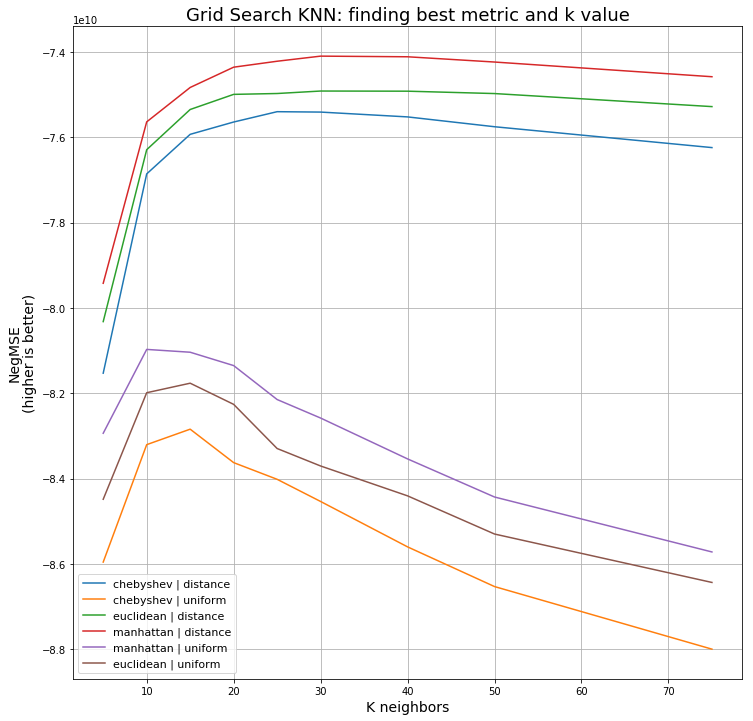

In [21]:
# Ploteo los resultados

ax = None
for df in dfs :
    df = df.reset_index()
    new_name = df.param_metric[0] + ' | ' + df.param_weights[0]
    df = df.rename(columns={'mean_test_MSE':new_name })
    ax = df.plot(ax=ax, x='param_n_neighbors', y=new_name, 
                 figsize=(12, 12))

ax.grid()
ax.set_title("Grid Search KNN: finding best metric and k value", fontsize=18)
ax.set_xlabel('K neighbors', fontsize=14)
ax.set_ylabel('NegMSE\n(higher is better)', fontsize=14)
ax.legend(fontsize=11);

In [22]:
print "\nMejores parametros:", gs.best_params_
print "Tuvieron un error de:", repr(-gs.best_score_), "midiendo como MSE"


Mejores parametros: {'n_neighbors': 30, 'metric': 'manhattan', 'weights': 'distance'}
Tuvieron un error de: 74097463619.108978 midiendo como MSE
